# Comparison of algorithms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from copy import deepcopy
from functools import partial
import os
from itertools import product
import json
import math
from sklearn.linear_model import LinearRegression
import seaborn as sns


In [2]:
import sys

sys.path.append("..")

from functions.utils import *
from functions.crossover import *
from functions.selection_algos import *
from functions.mutations import *
from functions.algorithms import *
from functions.solutions import *
from functions.stats_test import *

## Loading the best configuration for SA

In [3]:
results_file = "results/avg_fitness_by_generation_sa.csv"

final_res = pd.read_csv(results_file)


final_res["fitness_by_gen"] = final_res["fitness_by_gen"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_by_gen"].apply(lambda x: x[-1])

final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)
final_res_sorted["best_fitness"] = final_res_sorted["best_fitness"].apply(json.loads)
final_res_sa = final_res_sorted.iloc[0]

best_config_sa = final_res_sorted.iloc[0]
best_config_sa["configuration"]



"(100, 100, 'scramble_mutation_optimized', 3.0, 200, 1.01)"

## Loading the best configuration for GA

In [4]:
results_file = "results/avg_fitness_by_generation.csv"

final_res = pd.read_csv(results_file)


final_res["fitness_per_generation"] = final_res["fitness_per_generation"].apply(json.loads)
final_res["final_best_fitness_prun"] = final_res["final_best_fitness_prun"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_per_generation"].apply(lambda x: x[-1])
final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)
final_res_ga = final_res_sorted.iloc[0]

best_config_ga = final_res_sorted.iloc[0]
best_config_ga["configuration"]


'swap_mutation | group_preserving_order_crossover | rank(10.0) | xo=0.8 | mut=1.0 | elitism=True'

## Loading configuration for HC

In [5]:
hc_file = "results/hc_results.csv"

final_res = pd.read_csv(hc_file)
final_res["fitness_hists"] = final_res["fitness_hists"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_hists"].apply(lambda x: x[-1])
final_res["fitness_scores"] = final_res["fitness_scores"].apply(json.loads)

final_res_hc = final_res.iloc[0]

## Plot fitness evolution

> Since for HC we used 6 iterations we have in the end 10_752 fitness evaluations. <br>
To plot all the fitness scores until 10_000 we will use linear regression to predict the fitness score at 10_000 fitness evaluations for hill climbing (just for plot evaluation). 

In [6]:
x = np.array([1792 * i for i in range(0, 7)]).reshape(-1, 1)
y = np.array(final_res["fitness_hists"].iloc[0])

model = LinearRegression()
model.fit(x, y)

# Predict fitness at x = 10,000
x_pred = np.array([[10_000]])
y_pred = model.predict(x_pred)

print(f"Predicted fitness at 10,000 evaluations: {y_pred[0]:.2f}")

Predicted fitness at 10,000 evaluations: 38398.02


> We can see that SA and GA overperform HC, and that HC takes much more fitness evaluations to converge. <br>
> The SA finds faster a better solution (in the first 1000 FE), as it uses in this case a scramble mutation for neighbor selection exploring the solution space faster, but from 1000 FE GA is faster as it combines mutation with reproduction ensuring more diversity explore the fitness landscape. With enough iterations (FE) both GA and SA converge to a global optimum. <br>


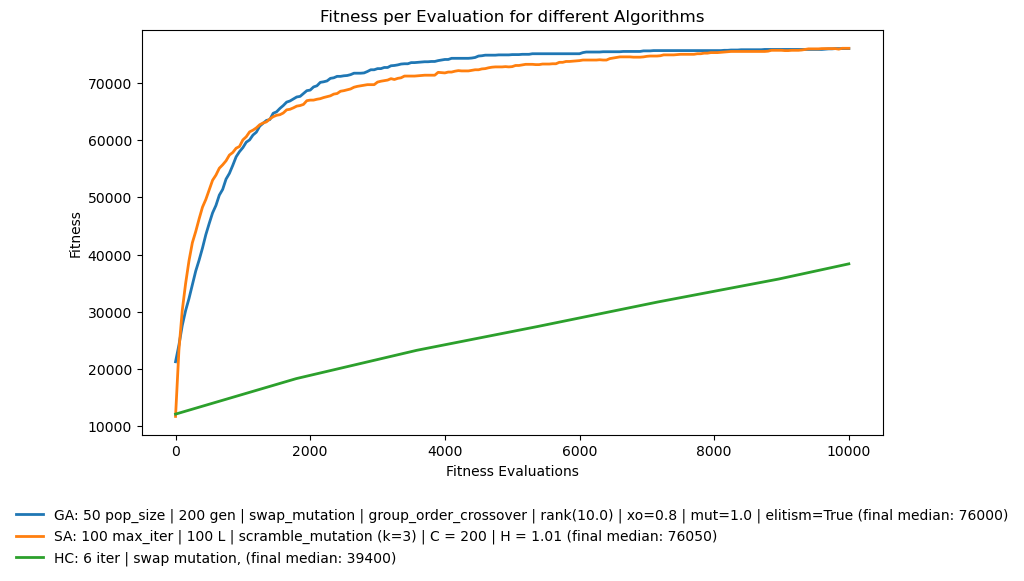

In [7]:
fitness_ga = best_config_ga["fitness_per_generation"]
fitness_sa = best_config_sa["fitness_by_gen"]
fitness_hc = final_res["fitness_hists"].iloc[0]
fitness_hc_plot = deepcopy(fitness_hc)
fitness_hc_plot[-1] = y_pred[0]

fitness_evaluations_per_iter = 50
fitness_eval_per_iter_hc = 1792

x_evals_ga = [i * fitness_evaluations_per_iter for i in range(len(fitness_ga))]
x_evals_sa = [i * fitness_evaluations_per_iter for i in range(len(fitness_sa))]
x_evals_hc = [i * fitness_eval_per_iter_hc for i in range(len(fitness_hc))]
x_evals_hc[-1] = 10_000


best_config_ga_label = f"50 pop_size | 200 gen | swap_mutation | group_order_crossover | rank(10.0) | xo=0.8 | mut=1.0 | elitism=True (final median: {round(fitness_ga[-1])})"
best_config_sa_label = f"100 max_iter | 100 L | scramble_mutation (k=3) | C = 200 | H = 1.01 (final median: {round(fitness_sa[-1])})" 
best_config_hc_label = f"6 iter | swap mutation, (final median: {round(fitness_hc[-1])})"  

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_evals_ga, fitness_ga, label=f"GA: {best_config_ga_label}", linewidth=2, color="tab:blue")
plt.plot(x_evals_sa, fitness_sa, label=f"SA: {best_config_sa_label}", linewidth=2, color="tab:orange")
plt.plot(x_evals_hc, fitness_hc_plot, label=f"HC: {best_config_hc_label}", linewidth=2, color="tab:green")

plt.title("Fitness per Evaluation for different Algorithms")
plt.xlabel("Fitness Evaluations")
plt.ylabel("Fitness")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=False
)

plt.tight_layout()
plt.show()


## Plot final fitness for 10,000 fitness evaluations

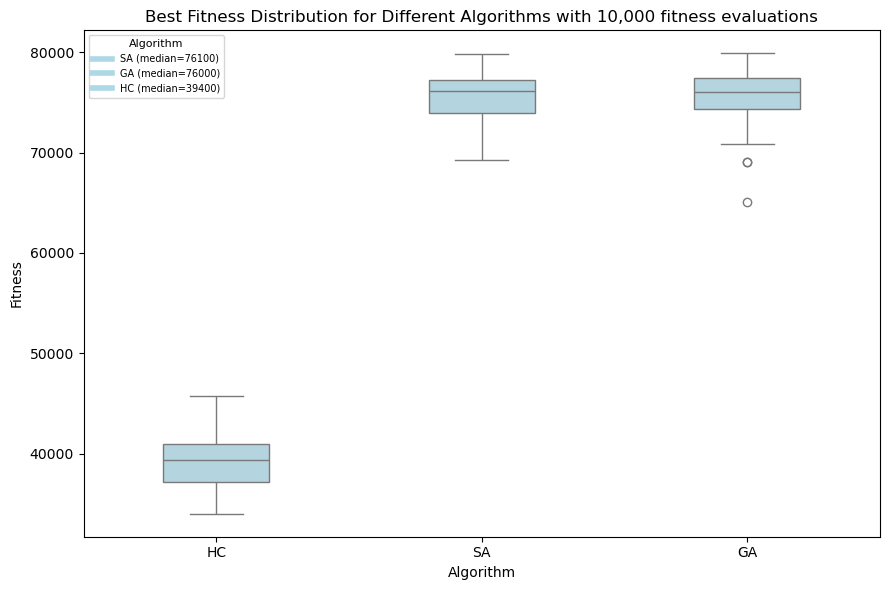

In [8]:
data = {
    "Fitness": (
        final_res_hc["fitness_scores"]
        + final_res_sa["best_fitness"]
        + final_res_ga["final_best_fitness_prun"]
    ),
    "Algorithm": (
        ["HC"] * len(final_res_hc["fitness_scores"])
        + ["SA"] * len(final_res_sa["best_fitness"])
        + ["GA"] * len(final_res_ga["final_best_fitness_prun"])
    )
}

df = pd.DataFrame(data)

plt.figure(figsize=(9, 6))
sns.boxplot(x="Algorithm", y="Fitness", data=df, width=0.4, color="lightblue")


medians = df.groupby("Algorithm")["Fitness"].median().round(0).astype(int)
medians_sorted = medians.sort_values(ascending=False)
handles = [
    plt.Line2D([0], [0], lw=4, label=f"{algo} (median={med})", color="lightblue")
    for algo, med in medians_sorted.items()
]
plt.legend(handles=handles, title="Algorithm", loc="upper left", fontsize=7, title_fontsize=8)


plt.title("Best Fitness Distribution for Different Algorithms with 10,000 fitness evaluations")
plt.ylabel("Fitness")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()


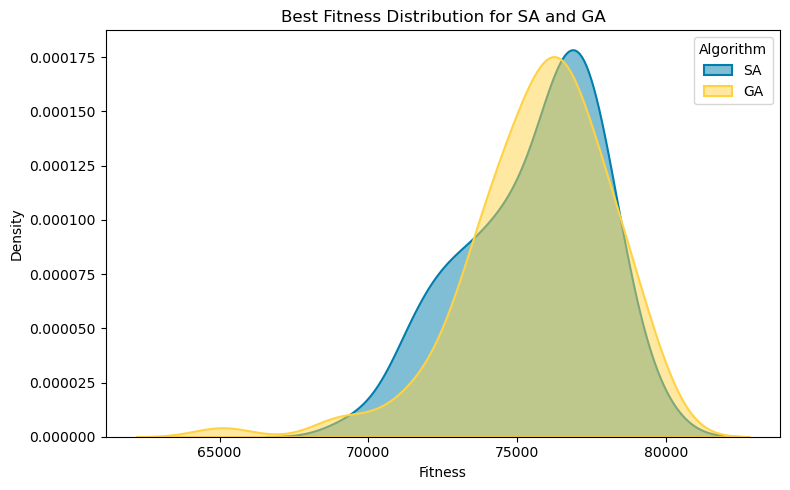

In [9]:
plot_fitness_distribution(
    df=df,
    column="Algorithm",
    palette={"SA":"#007ead","GA":"#ffd244"},
    title="Best Fitness Distribution for SA and GA",
    figsize=(8,5),
    x="Fitness"
)

> Mann Whitney U test shows that there's no difference in the final fitness after 10_000 FE for GA and SA 

In [10]:
sa = df[df["Algorithm"] == "SA"]["Fitness"].values
ga = df[df["Algorithm"] == "GA"]["Fitness"].values

mann_whitney_u_test(ga, sa, 0.05)

Mann-Whitney U statistic: 5202.000
P-value: 6.224e-01
----------------------------------------------------------------------------------------------------
FAIL TO REJECT H0: No significant difference.


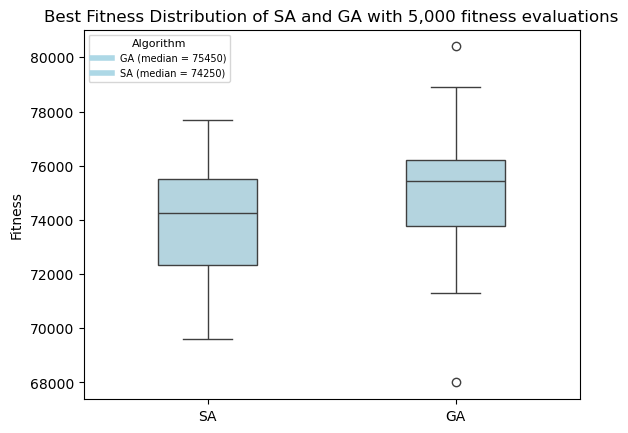

In [11]:
df_ga = pd.read_csv('results/ga_results.csv', index_col=0)

df_ga["fitness_scores"] = df_ga["fitness_scores"].apply(json.loads)

df_ga["final_best_fitness"] = df_ga["fitness_scores"].apply(np.median)
df_ga_sorted = df_ga.sort_values(by="final_best_fitness", ascending=False).reset_index(drop=True)
df_ga_sorted

best_config = df_ga_sorted.iloc[0]
best_config = best_config.drop(["final_best_fitness"])

df_sa = pd.read_csv('results/sa_results.csv')
df_sa["fitness_scores"] = df_sa["fitness_scores"].apply(json.loads)

best_config_sa = df_sa.iloc[0]
best_config_sa = best_config_sa.drop(["fitness_list", "fitness_median"])

best_config_ga = best_config.to_frame().T
best_config_ga = best_config_ga.explode("fitness_scores")
best_config_ga["fitness_scores"] = best_config_ga["fitness_scores"].astype(float)

best_config_sa = best_config_sa.to_frame().T
best_config_sa = best_config_sa.explode("fitness_scores")
best_config_sa["fitness_scores"] = best_config_sa["fitness_scores"].astype(float)

ga_values = best_config_ga["fitness_scores"].values
sa_values = best_config_sa["fitness_scores"].values

# Compute medians
ga_median = np.median(ga_values)
sa_median = np.median(sa_values)



sns.boxplot(data=[sa_values, ga_values], width=0.4, color="lightblue")
# Add custom legend with medians
handles = [
    plt.Line2D([0], [0], color="lightblue", lw=4, label=f"GA (median = {ga_median:.0f})"),
    plt.Line2D([0], [0], color="lightblue", lw=4, label=f"SA (median = {sa_median:.0f})"),
]
plt.legend(handles=handles, title="Algorithm", loc="upper left", fontsize=7, title_fontsize=8)

plt.xticks([0, 1], ["SA", "GA"])
plt.ylabel("Fitness")
plt.title("Best Fitness Distribution of SA and GA with 5,000 fitness evaluations")
plt.show()

In [12]:
mann_whitney_u_test(ga_values, sa_values, 0.05)

Mann-Whitney U statistic: 595.500
P-value: 3.195e-02
----------------------------------------------------------------------------------------------------
REJECT H0: Groups differ significantly.
Rank-biserial correlation: 0.323
